# Evaluating Equitable TOD Indicators in Prince George’s County: Greenbelt and College Park Case Study

## Problem Statement and Central Question

Prince George’s County, Maryland, has a robust transit infrastructure, including multiple WMATA Metrorail and MARC commuter rail stations. Despite the County's goals in Plan Prince George’s 2035 to promote equitable, compact, and transit-oriented development (TOD), much of the land near transit stations remains locked in low-density, single-family residential zoning.

This study explores the central question: To what extent is Prince George’s County leveraging its transit assets to align with national TOD best practices and promote equitable, sustainable growth? Focusing on the Greenbelt and College Park–University of Maryland stations, we analyze zoning, land use, and development potential within a half-mile radius of each station.

## Data and Methods

To evaluate TOD alignment and equity, a spatial analysis framework was employed, using a 0.5-mile buffer around each station. This corresponds to a typical ten-minute walk radius. Data was sourced from Prince George’s County GIS portals, supplemented by local zoning ordinance descriptions.

Key indicators analyzed include:
- **Built Density**: Residential dwelling units per acre.
- **Allowed Density**: Maximum permitted density under current zoning.
- **Underutilization Ratio**: The ratio of allowed to built density, indicating untapped development capacity.
- **Land Use and Zoning Composition**: Breakdown of residential, commercial, and institutional uses.
- **Ownership and Occupancy Rates**: Analysis of owner vs. renter-occupied properties.

Code for data processing and visualization is implemented in separate modules, which are imported and utilized below:

### 1. Load Packages

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

### 2. Load Modules

In [11]:
from modules.data_loader import load_geodata
from modules.preprocessing import reproject_all, create_buffer, filter_parcels
from modules.density import assign_allowed_density, calculate_densities
from modules.summarizer import summarize
from modules.zoning_map import plot_zoning_map

### 3. Data Loading and Reprojection:
The analysis begins by loading the relevant geospatial datasets, including the metro buffers, metro stations, municipal boundary, and property parcels. These datasets are then reprojected to a consistent coordinate reference system (CRS) to ensure compatibility in spatial operations. The function load_geodata() loads the datasets, while reproject_all() ensures all data layers align spatially by reprojecting them to a common CRS.

In [12]:
# Load and reproject data
metro_buffer, metro_stations, muni_boundary, property_gdf = load_geodata()
metro_buffer, metro_stations, muni_boundary, property_gdf = reproject_all(
    [metro_buffer, metro_stations, muni_boundary, property_gdf]
)

### 4. Buffer Creation and Selection:
Buffers of varying sizes (0.5-mile) are created around metro stations to delineate the areas of interest for the analysis. These buffers allow for the identification of parcels within a set distance of transit stations, which are critical in TOD assessments. The buffers are created using the create_buffer() function, with specific attention to the Greenbelt, College Park-U of Md station areas.

In [13]:
# Setup buffers
metro_union = metro_buffer.unary_union
pg_metro_buffer = property_gdf[property_gdf.geometry.within(metro_union)].copy()

greenbelt_geom = create_buffer(metro_stations, 'Greenbelt')
cpumd_geom = create_buffer(metro_stations, 'College Park-U of Md')
cp_geom = muni_boundary[muni_boundary['CITY'] == 'College Park'].geometry.unary_union

### 5. Parcel Filtering:
For each of the defined areas (Greenbelt, College Park-U of Md), parcels are filtered from the broader property dataset. This ensures that only those parcels within the buffers or the city boundary are included in the analysis. The filter_parcels() function selects parcels that fall within the defined buffer zones, focusing on areas in close proximity to transit.

In [14]:
# Filter parcel groups
greenbelt_cp = filter_parcels(property_gdf, greenbelt_geom, cp_geom)
cpumd_cp = filter_parcels(property_gdf, cpumd_geom, cp_geom)
cp_city = property_gdf[property_gdf.geometry.within(cp_geom)]

### 6. Density Calculations:
Density is calculated for each of the filtered datasets and used for evaluating the level of development in the study areas. Higher densities near transit  are associated with better TOD alignment. The calculate_densities() function computes the density of each parcel, which helps determine the spatial distribution of development.

In [15]:
# Calculate density metrics
property_gdf = calculate_densities(property_gdf)
greenbelt_cp = calculate_densities(greenbelt_cp)
cpumd_cp = calculate_densities(cpumd_cp)
cp_city = calculate_densities(cp_city)
pg_metro_buffer = calculate_densities(pg_metro_buffer)

### 7. Summary of Results:
After calculating densities for each area of interest, a summary of the findings is generated to evaluate the level of TOD alignment in each region. This includes determining the allowed densities for different zoning classifications and summarizing the results for the analysis areas. The summarize() function provides a summary of each area, including the assigned densities based on the zoning regulations.

In [16]:
# Summarize
summarize(pg_metro_buffer, "Prince George's One Mile Metro Buffer", assign_allowed_density)
summarize(cp_city, "College Park City", assign_allowed_density)
summarize(greenbelt_cp, "Greenbelt Half-Mile Buffer", assign_allowed_density)
summarize(cpumd_cp, "College Park-U of Md Half-Mile Buffer", assign_allowed_density)


Prince George's One Mile Metro Buffer Summary
 - Total Units: 73179.00
 - Total Acres: 12283.48
 - Built Density: 5.96
 - Allowed Density: 52.05
 - Underutilized Parcels: 11128
 - Underutilization Ratio: 0.75
         Percent  Count
ZONE_1                 
RSF-65     61.78  23826
RSF-A      21.08   8129
RSF-95      4.04   1557
LTO-C       2.81   1084
RR          2.03    784
LTO-E       1.63    628
RTO-L-E     1.48    569
RTO-H-E     1.21    467
RMF-48      1.01    388
RMF-20      0.83    321
RMF-12      0.62    238
RTO-H-C     0.60    232
NAC         0.58    224
RTO-L-C     0.20     79
IE          0.03     12
AG          0.02      8
CGO         0.02      6
LMUTC       0.01      4
IH          0.01      3
ROS         0.01      3
CS          0.00      1
CN          0.00      1

College Park City Summary
 - Total Units: 8964.00
 - Total Acres: 1328.04
 - Built Density: 6.75
 - Allowed Density: 33.76
 - Underutilized Parcels: 988
 - Underutilization Ratio: 0.80
         Percent  Count
ZONE

### 8. Zoning Visualization:
To visualize the zoning classifications, a color map is applied to different zones based on their land use designation. The plot_zoning_map() function is used to generate a map that overlays these zoning areas with the corresponding buffers, showing the areas where transit-oriented development could be better supported or aligned. The zoning map is generated to visualize the zoning designations and how they correspond with the buffer zones, allowing for an easier comparison of zoning patterns with TOD potential.

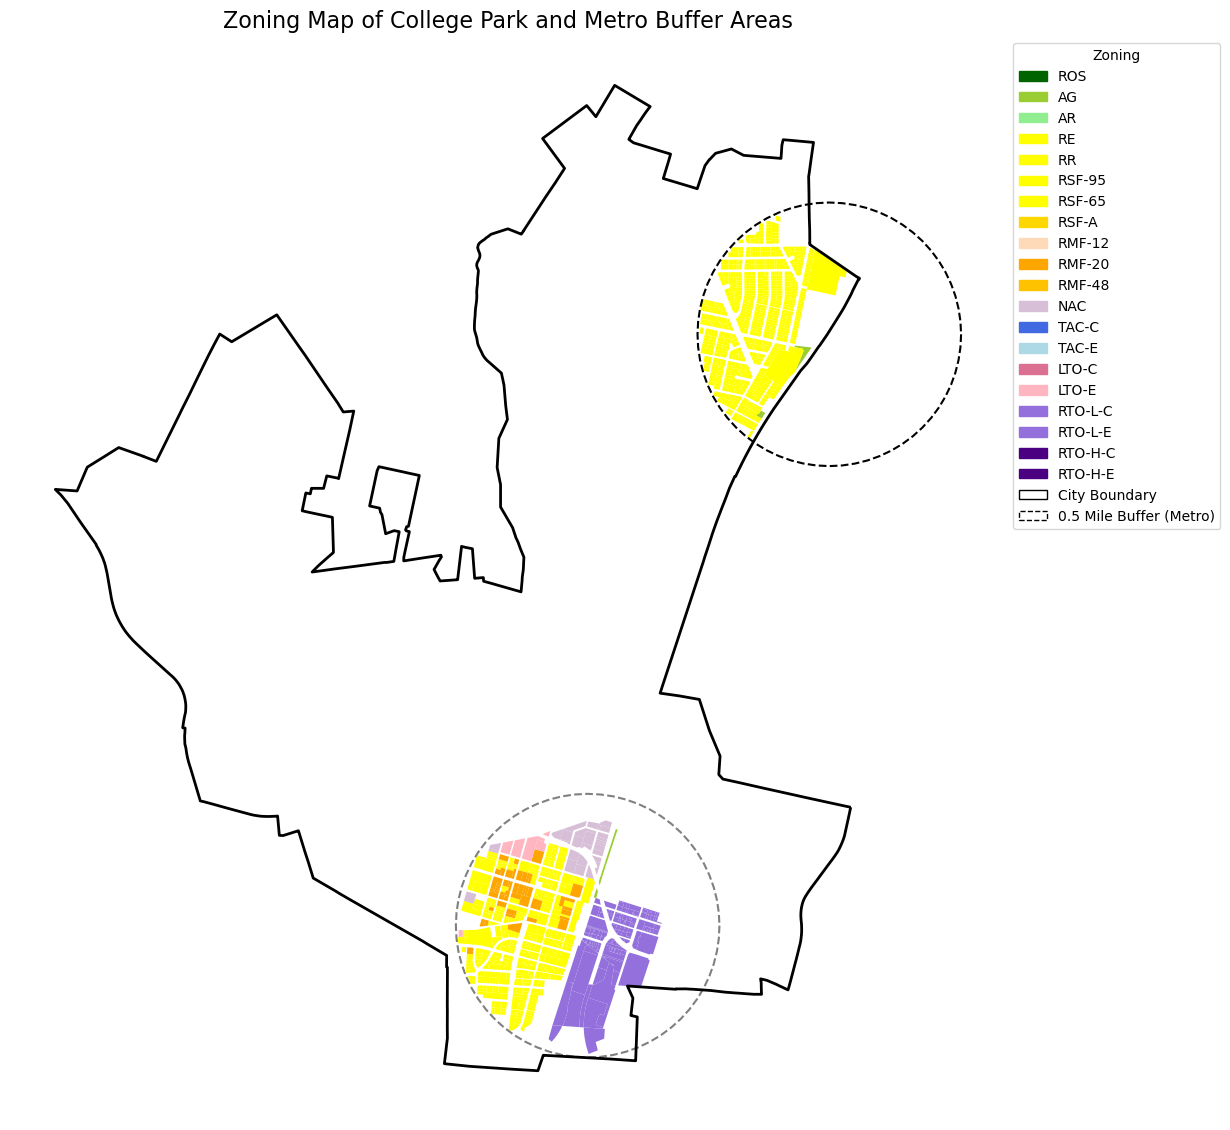

In [17]:
# -- Data Preparation --
zones_of_interest = pd.concat([greenbelt_cp, cpumd_cp])

zone_color_map = {
    'ROS': 'darkgreen', 'AG': 'yellowgreen', 'AR': 'lightgreen',
    'RE': 'yellow', 'RR': 'yellow', 'RSF-95': 'yellow', 'RSF-65': 'yellow',
    'RSF-A': '#FFD700', 'RMF-12': '#FFDAB9', 'RMF-20': '#FFA500',
    'RMF-48': '#FFC200', 'NAC': '#D8BFD8', 'TAC-C': '#4169E1',
    'TAC-E': '#ADD8E6', 'LTO-C': '#DB7093', 'LTO-E': '#FFB6C1',
    'RTO-L-C': '#9370DB', 'RTO-L-E': '#9370DB', 'RTO-H-C': '#4B0082',
    'RTO-H-E': '#4B0082'
}

zones_of_interest['zone_color'] = zones_of_interest['ZONE_1'].map(zone_color_map)
zones_of_interest = zones_of_interest.dropna(subset=['zone_color'])

# -- Plot Zoning Map --
plot_zoning_map(zones_of_interest, greenbelt_geom, cpumd_geom, cp_geom, zone_color_map)

## Findings

### Greenbelt Station (within College Park limits)

- **Total Dwelling Units**: 676
- **Total Acres**: 118.71
- **Built Density**: 5.69 dwelling units/acre
- **Allowed Density**: 6.70 dwelling units/acre
- **Underutilization Ratio**: 1.06 (low)

The Greenbelt station area demonstrates modest existing density, with limited room for development under current zoning. Nearly all parcels are zoned RSF-65, a low-density single-family residential zone, which severely restricts opportunities for TOD.

### College Park–U of Md Station (within College Park limits)

- **Total Dwelling Units**: 646
- **Total Acres**: 205.74
- **Built Density**: 3.14 dwelling units/acre
- **Allowed Density**: 71.68 dwelling units/acre
- **Underutilization Ratio**: 0.59 (high)

Unlike Greenbelt, the College Park area has greater zoning flexibility, including RTO and RMF-20 zones, which allow for more intense development. Despite this, significant underutilization remains, with high potential for TOD.

While zoning near the College Park station shows progress toward aligning land use with transit goals, the Greenbelt station area remains overwhelmingly constrained by outdated zoning practices that prioritize exclusivity and automobile dependence.

## Next Steps
While this analysis provides a foundation for understanding zoning alignment with transit-oriented development (TOD), several additional steps can further refine and expand the findings:

**Expand Buffer Areas and Temporal Analysis:**
Extending the buffer areas to include larger distances from metro stations (e.g., 1-mile buffers) could provide a more comprehensive view of TOD potential. Additionally, performing a temporal analysis to track changes in zoning and land use over time could help assess the effectiveness of policy changes aimed at increasing TOD.

**Integration of Additional Data Layers:**
Integrating additional layers, such as demographic data, environmental factors (e.g., flood risk or green space), and infrastructure development, would provide a more holistic view of the area’s suitability for TOD. Including data on transportation accessibility and walkability would also deepen the analysis.

**Community Engagement:**
Engaging with local communities, stakeholders, and policy experts could provide qualitative insights into the practical feasibility of TOD in these areas. Surveys or interviews could help identify potential barriers to development, such as community opposition or infrastructure limitations.

**Zoning Policy Recommendations:**
Based on the findings, targeted zoning policy recommendations could be developed to encourage higher-density development near transit stations. These recommendations could focus on easing zoning restrictions for multi-family housing or introducing incentives for developers to build affordable housing within TOD zones.

**Advanced Spatial Modeling:**
Future work could involve the application of advanced spatial modeling techniques, such as suitability analysis or scenario modeling, to predict future development patterns based on different zoning and infrastructure interventions. This would help in assessing long-term trends and guiding sustainable urban growth.

**Stakeholder Collaboration for Implementation:**
Collaboration with local governments, urban planners, and developers could help translate these findings into actionable projects. By working together, stakeholders can ensure that the proposed zoning changes align with broader goals for sustainable urban development, economic growth, and community well-being.

## Data Sources and References
- Property and Zoning Shapefiles: <br>
Retrieved from Prince George’s County GIS Open Data Portal:
[https://gisdata.pgplanning.org/opendata/]

- Zoning Allowable Density Standards: <br>
Retrieved from the Prince George’s County Zoning Ordinance:
[https://online.encodeplus.com/regs/princegeorgescounty-md/doc-viewer.aspx#secid-634]

## Notes
- All data files must be placed in the data/ directory.
- Be sure to install necessary Python packages before running the notebook.